# Praktische Optimierung Blatt 10
### Tobias Lotz:  217856 <br>
### Alexander van der Staay:  185444

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from functools import partial
from pymoo.problems import get_problem
from pymoo.optimize import minimize as moo_min
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import HV

# 10.1

$f(x) = \left(\begin{array}{c} \sqrt{\lvert x \rvert} \\ x \cdot \cos{x}  \end{array}\right), \space \space \space x \in [-10, 10]$ <br> <br>

In [2]:
LOWER = -10
UPPER = 10

def f(x): return np.array([np.sqrt(np.abs(x)), x * np.cos(x)])

In [3]:
x = np.linspace(LOWER, UPPER, 1001)

y1s, y2s = f(x)

### Paretomenge

In [4]:
def dominates(a, b):
    if a[0] < b[0]:
        return a[1] <= b[1]
    elif a[0] == b[0]:
        return a[1] < b[1]
    return False

In [5]:
pareto_x = []
pareto_y1 = []
pareto_y2 = []
for i in range(1001):
    c_y1 = y1s[i]
    c_y2= y2s[i]
    non_dominated = True
    for j in range(1001):
        if dominates([y1s[j], y2s[j]], [c_y1, c_y2]):
            non_dominated = False
            break
    if non_dominated:
        pareto_y1.append(c_y1)
        pareto_y2.append(c_y2)
        pareto_x.append(x[i])

pareto_y1 = np.array(pareto_y1)
pareto_y2 = np.array(pareto_y2)

### Visualisierung

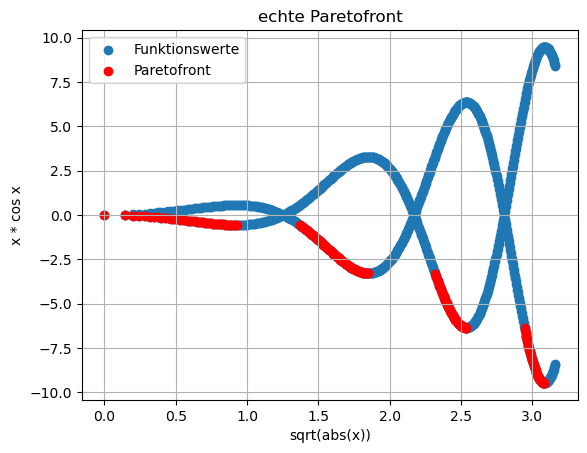

In [6]:
fig, ax = plt.subplots()
ax.grid()
ax.set_title('echte Paretofront')
ax.scatter(y1s, y2s)
ax.set_ylabel('x * cos x')
ax.set_xlabel('sqrt(abs(x))')
ax.scatter(pareto_y1, pareto_y2, c='red')
ax.legend(labels=['Funktionswerte', 'Paretofront'])

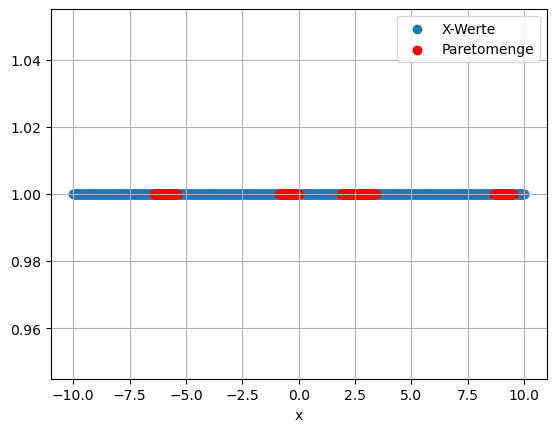

In [7]:
fig, ax = plt.subplots()
ax.grid()
ax.scatter(x, np.ones_like(x))
ax.scatter(pareto_x, np.ones_like(pareto_x), c='red')
ax.set_xlabel('x')
ax.legend(labels=['X-Werte', 'Paretomenge'])

### (i) Gewichtete Summe

In [8]:
def f1(x): return np.sqrt(np.abs(x))
def f2(x): return x * np.cos(x)

In [9]:
def minimize_weighted_sum(funcs, lower, upper, n_points=100, seed=1):
    np.random.seed(seed)
    xs = np.random.uniform(lower, upper, n_points)
    w1s = np.random.uniform(0.0, 1.0, n_points)
    w2s = 1 - w1s
    solutions = []
    for i in range(n_points):
        for w1, w2 in list(zip(w1s, w2s)):
            def z(x): return w1 * funcs[0](x) + w2 * funcs[1](x)
            res = minimize(z, np.array([xs[i]]), method='L-BFGS-B', bounds=[(LOWER, UPPER)])
            solutions.append(res['x'][0])
    return solutions

In [10]:
res_ws = minimize_weighted_sum([f1, f2], LOWER, UPPER)

found_y1 = f1(res_ws)
found_y2 = f2(res_ws)

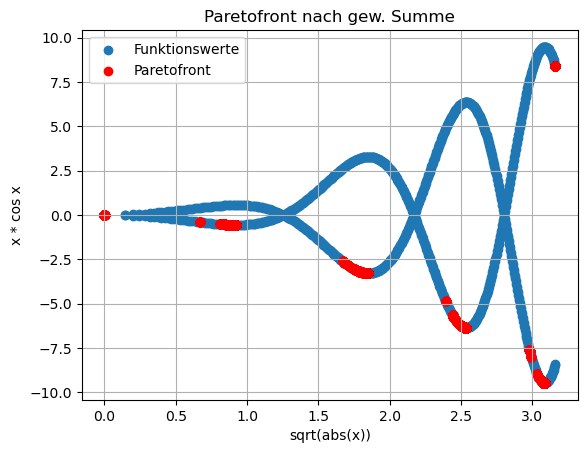

In [11]:
fig, ax = plt.subplots()
ax.grid()
ax.set_title('Paretofront nach gew. Summe')
ax.scatter(y1s, y2s)
ax.set_ylabel('x * cos x')
ax.set_xlabel('sqrt(abs(x))')
ax.scatter(found_y1, found_y2, c='red')
ax.legend(labels=['Funktionswerte', 'Paretofront'])

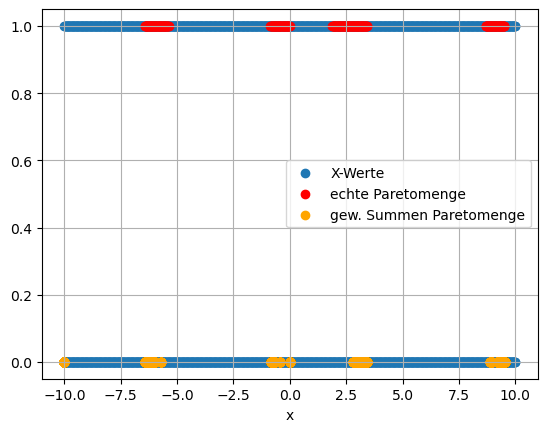

In [12]:
fig, ax = plt.subplots()
ax.grid()
ax.scatter(np.concatenate([x, x]), np.concatenate([np.ones_like(x), np.zeros_like(x)]))
ax.scatter(pareto_x, np.ones_like(pareto_x), c='red')
ax.set_xlabel('x')

ax.scatter(res_ws, np.zeros_like(res_ws), c='orange')
ax.legend(labels=['X-Werte', 'echte Paretomenge', 'gew. Summen Paretomenge'])

### (ii) Referenzpunkte

$r = 1$

In [53]:
def minimize_reference_points_r1(funcs, lower, upper, n_points=100, seed=1):
    np.random.seed(seed)
    xs = np.random.uniform(lower, upper, n_points)
    refs = np.random.uniform(low=[0.0, -10.0], high=[4.0, 10.0], size=(n_points, 2))
    solutions = []
    for x0 in xs:
        for ref in refs:
            def z1(x): return np.abs(ref[0] - funcs[0](x)) + np.abs(ref[1] - funcs[1](x))
            res = minimize(z1, np.array(x0), method='L-BFGS-B', bounds=[(LOWER, UPPER)])
            solutions.append(res['x'][0])
    return solutions

In [54]:
res_rp1 = minimize_reference_points_r1([f1, f2], LOWER, UPPER)

found_y1 = f1(res_rp1)
found_y2 = f2(res_rp1)

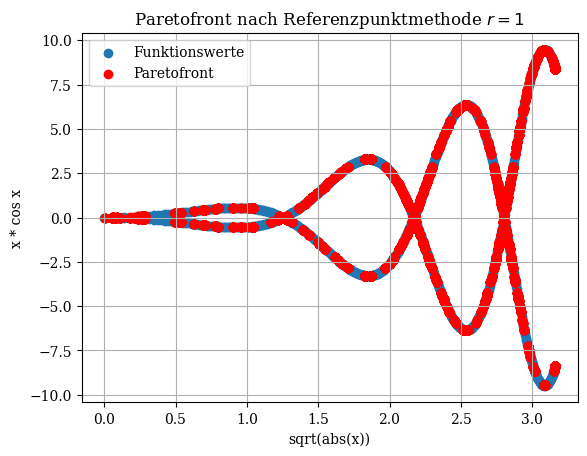

In [55]:
fig, ax = plt.subplots()
ax.grid()
ax.set_title('Paretofront nach Referenzpunktmethode $r=1$')
ax.scatter(y1s, y2s)
ax.set_ylabel('x * cos x')
ax.set_xlabel('sqrt(abs(x))')
ax.scatter(found_y1, found_y2, c='red')
ax.legend(labels=['Funktionswerte', 'Paretofront'])

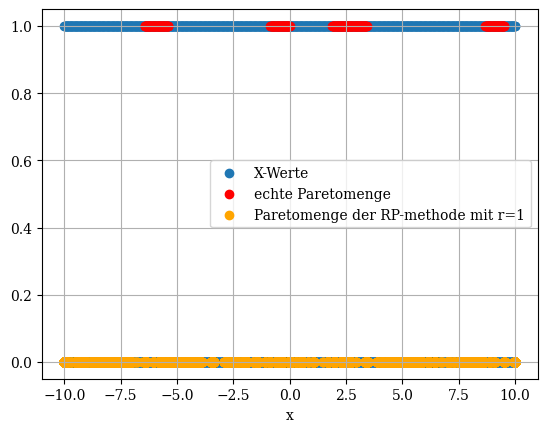

In [56]:
fig, ax = plt.subplots()
ax.grid()
ax.scatter(np.concatenate([x, x]), np.concatenate([np.ones_like(x), np.zeros_like(x)]))
ax.scatter(pareto_x, np.ones_like(pareto_x), c='red')
ax.set_xlabel('x')

ax.scatter(res_rp1, np.zeros_like(res_rp1), c='orange')
ax.legend(labels=['X-Werte', 'echte Paretomenge', 'Paretomenge der RP-methode mit r=1'])

$r = 2$

In [17]:
def minimize_reference_points_r2(funcs, lower, upper, n_points=100, seed=1):
    np.random.seed(seed)
    xs = np.random.uniform(lower, upper, n_points)
    refs = np.random.uniform(low=[0.0, -10.0], high=[4.0, 10.0], size=(n_points, 2))
    solutions = []
    for x0 in xs:
        for ref in refs:
            def z1(x): return np.sqrt((ref[0] - funcs[0](x))**2 + (ref[1] - funcs[1](x))**2)
            res = minimize(z1, np.array(x0), method='L-BFGS-B', bounds=[(LOWER, UPPER)])
            solutions.append(res['x'][0])
    return solutions

In [18]:
res_rp2 = minimize_reference_points_r2([f1, f2], LOWER, UPPER)

found_y1 = f1(res_rp2)
found_y2 = f2(res_rp2)

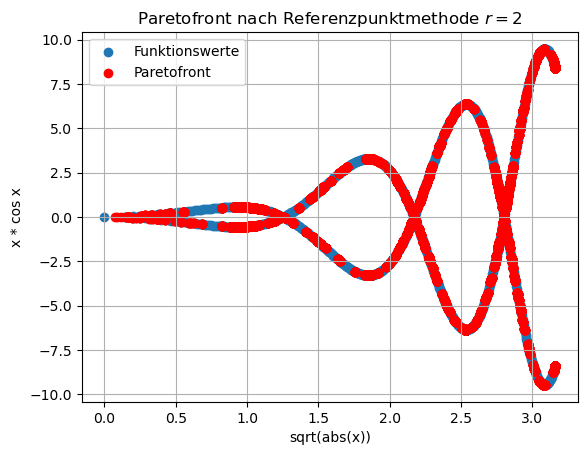

In [19]:
fig, ax = plt.subplots()
ax.grid()
ax.set_title('Paretofront nach Referenzpunktmethode $r = 2$')
ax.scatter(y1s, y2s)
ax.set_ylabel('x * cos x')
ax.set_xlabel('sqrt(abs(x))')
ax.scatter(found_y1, found_y2, c='red')
ax.legend(labels=['Funktionswerte', 'Paretofront'])

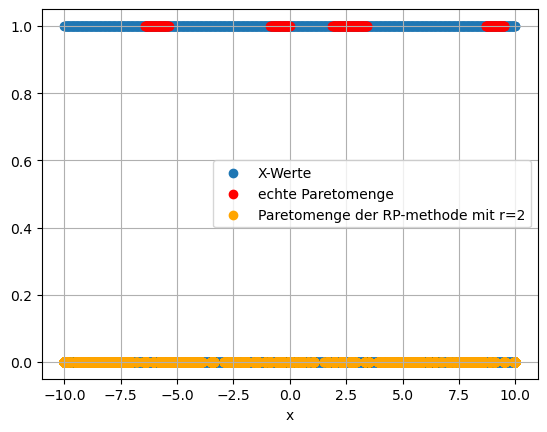

In [20]:
fig, ax = plt.subplots()
ax.grid()
ax.scatter(np.concatenate([x, x]), np.concatenate([np.ones_like(x), np.zeros_like(x)]))
ax.scatter(pareto_x, np.ones_like(pareto_x), c='red')
ax.set_xlabel('x')

ax.scatter(res_rp1, np.zeros_like(res_rp1), c='orange')
ax.legend(labels=['X-Werte', 'echte Paretomenge', 'Paretomenge der RP-methode mit r=2'])

r = $\infty$

In [21]:
def minimize_reference_points_rinf(funcs, lower, upper, n_points=100, seed=1):
    np.random.seed(seed)
    xs = np.random.uniform(lower, upper, n_points)
    refs = np.random.uniform(low=[0.0, -10.0], high=[4.0, 10.0], size=(n_points, 2))
    solutions = []
    for x0 in xs:
        for ref in refs:
            def z1(x): return np.max([np.abs(ref[0] - funcs[0](x)), np.abs(ref[1] - funcs[1](x))])
            res = minimize(z1, np.array(x0), method='L-BFGS-B', bounds=[(LOWER, UPPER)])
            solutions.append(res['x'][0])
    return solutions

In [22]:
res_rp_inf = minimize_reference_points_rinf([f1, f2], LOWER, UPPER)

found_y1 = f1(res_rp_inf)
found_y2 = f2(res_rp_inf)

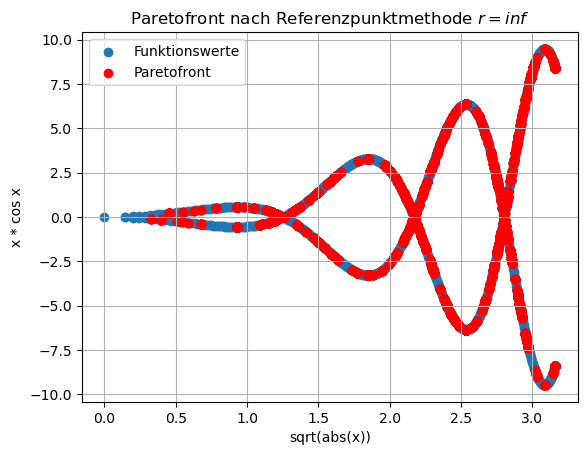

In [23]:
fig, ax = plt.subplots()
ax.grid()
ax.set_title('Paretofront nach Referenzpunktmethode $r = inf$')
ax.scatter(y1s, y2s)
ax.set_ylabel('x * cos x')
ax.set_xlabel('sqrt(abs(x))')
ax.scatter(found_y1, found_y2, c='red')
ax.legend(labels=['Funktionswerte', 'Paretofront'])

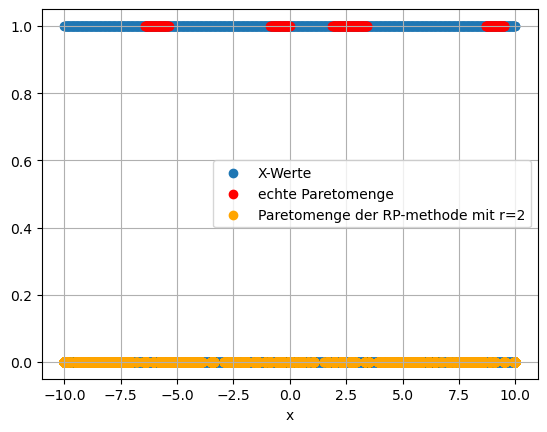

In [24]:
fig, ax = plt.subplots()
ax.grid()
ax.scatter(np.concatenate([x, x]), np.concatenate([np.ones_like(x), np.zeros_like(x)]))
ax.scatter(pareto_x, np.ones_like(pareto_x), c='red')
ax.set_xlabel('x')

ax.scatter(res_rp1, np.zeros_like(res_rp1), c='orange')
ax.legend(labels=['X-Werte', 'echte Paretomenge', 'Paretomenge der RP-methode mit r=2'])

### Kompromissmethode 

In [25]:
def compromise(funcs, x, epsilon):
    min = np.Inf
    y_1 = funcs[0](x)
    y_2 = funcs[1](x)
    if y_1 <= epsilon[0]:
        min = y_2
    if y_2 <= epsilon[1]:
        min = np.min([min, y_1])
    return min

In [62]:
def generate_xs(funs, epsilon, lower, upper, n_points=100, seed=1):
    np.random.seed(seed)
    c = 0
    xs = []
    while c < n_points:
        x = np.random.uniform(lower, upper)
        if funs[0](x) <= epsilon:
            xs.append(x)
            c += 1
    return np.array(xs)

In [90]:
def minimize_compromise(funcs, lower, upper, epsilon, n_points=100, seed=1):
    np.random.seed(seed)
    solutions = []
    for ep in epsilon:
        xs = generate_xs(funcs, ep, lower, upper, n_points=n_points)
        for x0 in xs:
            def z(x): 
                if funcs[0](x) <= ep: 
                    return funcs[1](x)
                return np.Inf
            res = minimize(z , np.array(x0), method='L-BFGS-B', bounds=[(LOWER, UPPER)])
            solutions.append(res['x'][0])
    return solutions

In [28]:
epsilon=np.linspace(0.1, 3.5, 1001)

In [93]:
res_comp = minimize_compromise([f1, f2], LOWER, UPPER, epsilon=np.linspace(0.1, 3.5, 1001), n_points=5)

found_y1 = f1(res_comp)
found_y2 = f2(res_comp)

In [87]:
found_y2

array([-0.56109634, -0.56109634, -0.56109634, -0.56109634, -0.56109634])

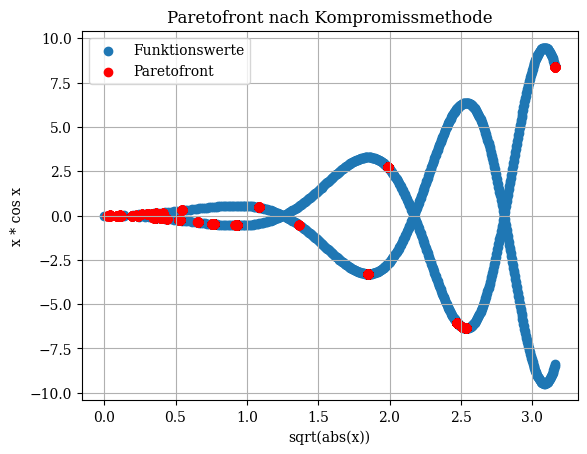

In [94]:
fig, ax = plt.subplots()
ax.grid()
ax.set_title('Paretofront nach Kompromissmethode')
ax.scatter(y1s, y2s)
ax.set_ylabel('x * cos x')
ax.set_xlabel('sqrt(abs(x))')
ax.scatter(found_y1, found_y2, c='red')
ax.legend(labels=['Funktionswerte', 'Paretofront'])

# 10.2

In [32]:
zdt1 = get_problem('zdt1')
zdt3 = get_problem('zdt3')
dtlz2 = get_problem('dtlz2')

### (i)

In [33]:
nsga2 = NSGA2(pop_size=20)

pareto_nsga2_zdt1 = []
pareto_nsga2_zdt3 = []
pareto_nsga2_dtlz2 = []

for _ in range(20):
    pareto_nsga2_zdt1.append(moo_min(zdt1,  nsga2, ('n_gen', 200), verbose=False).F)
    pareto_nsga2_zdt3.append(moo_min(zdt3,  nsga2, ('n_gen', 200), verbose=False).F)
    pareto_nsga2_dtlz2.append(moo_min(dtlz2, nsga2, ('n_gen', 200), verbose=False).F)

### (ii)

In [34]:
sms = SMSEMOA(pop_size=20)

pareto_sms_zdt1 = []
pareto_sms_zdt3 = []
pareto_sms_dtlz2 = []

for _ in range(20):
    pareto_sms_zdt1.append(moo_min(zdt1,   sms, ('n_gen', 200), verbose=False).F)
    pareto_sms_zdt3.append(moo_min(zdt3,   sms, ('n_gen', 200), verbose=False).F)
    pareto_sms_dtlz2.append(moo_min(dtlz2, sms, ('n_gen', 200), verbose=False).F)

### (iii)

In [35]:
two_d = HV([10, 10])
three_d = HV([10, 10, 10])

hv_nsga2_zdt1 = []
hv_nsga2_zdt3 = []
hv_nsga2_dtlz2 = []

hv_sms_zdt1 = []
hv_sms_zdt3 = []
hv_sms_dtlz2 = []

for i in range(20):
    hv_nsga2_zdt1.append(two_d(pareto_nsga2_zdt1[i]))
    hv_nsga2_zdt3.append(two_d(pareto_nsga2_zdt3[i]))
    hv_nsga2_dtlz2.append(three_d(pareto_nsga2_dtlz2[i]))

    hv_sms_zdt1.append(two_d(pareto_sms_zdt1[i]))
    hv_sms_zdt3.append(two_d(pareto_sms_zdt1[i]))
    hv_sms_dtlz2.append(three_d(pareto_sms_dtlz2[i]))


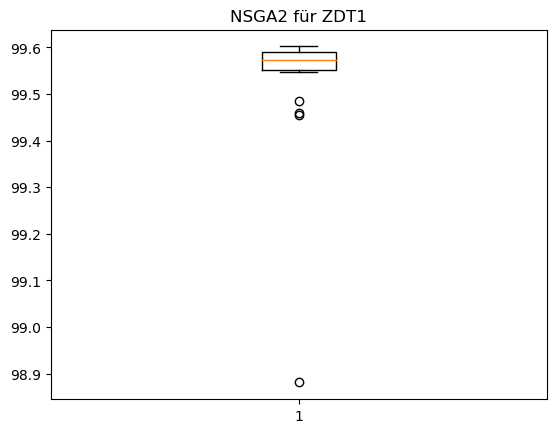

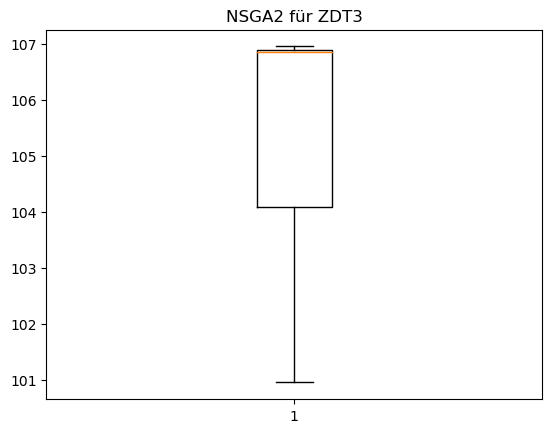

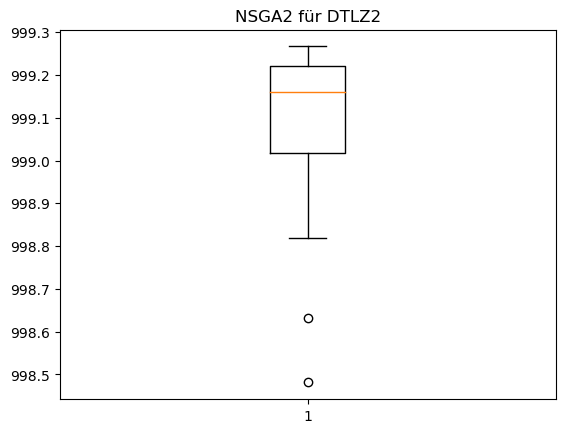

In [36]:
plt.boxplot(hv_nsga2_zdt1)
plt.title("NSGA2 für ZDT1")
plt.show()
plt.boxplot(hv_nsga2_zdt3)
plt.title("NSGA2 für ZDT3")
plt.show()
plt.boxplot(hv_nsga2_dtlz2)
plt.title("NSGA2 für DTLZ2")
plt.show()

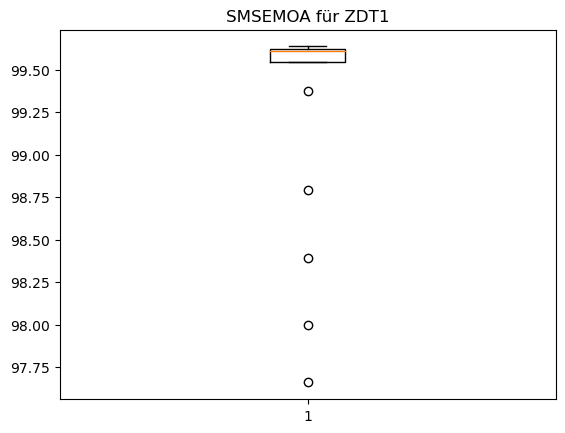

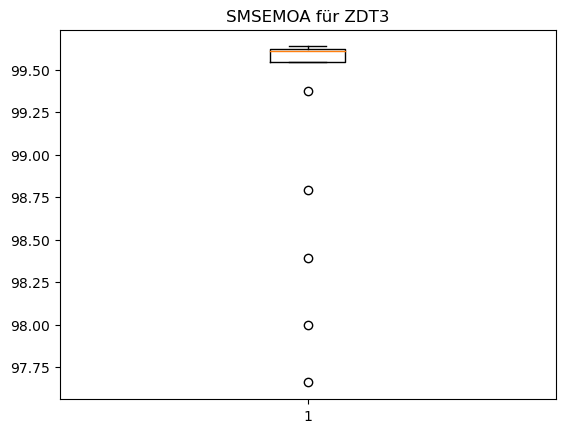

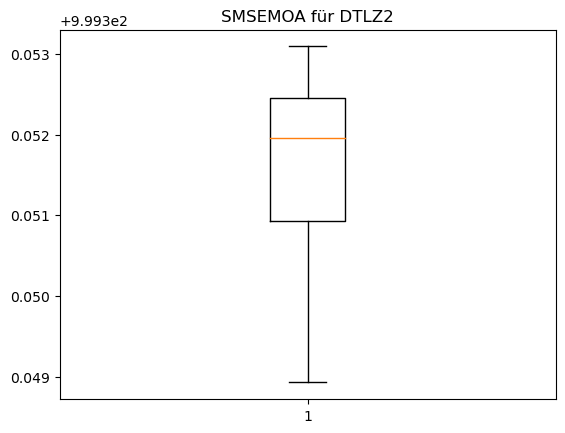

In [37]:
plt.boxplot(hv_sms_zdt1)
plt.title("SMSEMOA für ZDT1")
plt.show()
plt.boxplot(hv_sms_zdt3)
plt.title("SMSEMOA für ZDT3")
plt.show()
plt.boxplot(hv_sms_dtlz2)
plt.title("SMSEMOA für DTLZ2")
plt.show()

### (iv)

Zur Übersichtlichkeit ist hier nur die approximierte Parentofront von einer Wiederholung eingezeichnet

In [38]:
nsga2 = NSGA2(pop_size=20)

nsga2_zdt1  = moo_min(zdt1,  nsga2, ('n_gen', 200), verbose=False)
nsga2_zdt3  = moo_min(zdt3,  nsga2, ('n_gen', 200), verbose=False)
nsga2_dtlz2 = moo_min(dtlz2, nsga2, ('n_gen', 200), verbose=False)

In [39]:
sms = SMSEMOA(pop_size=20)

sms_zdt1  = moo_min(zdt1,  sms, ('n_gen', 200), verbose=False)
sms_zdt3  = moo_min(zdt3,  sms, ('n_gen', 200), verbose=False)
sms_dtlz2 = moo_min(dtlz2, sms, ('n_gen', 200), verbose=False)

### NSGA2

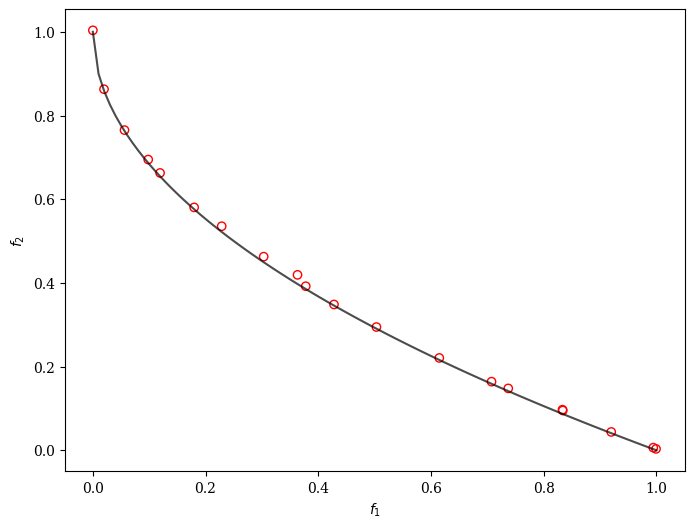

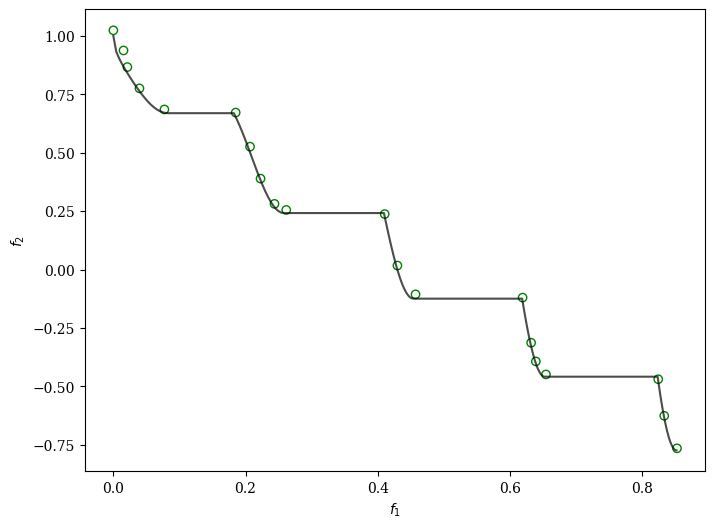

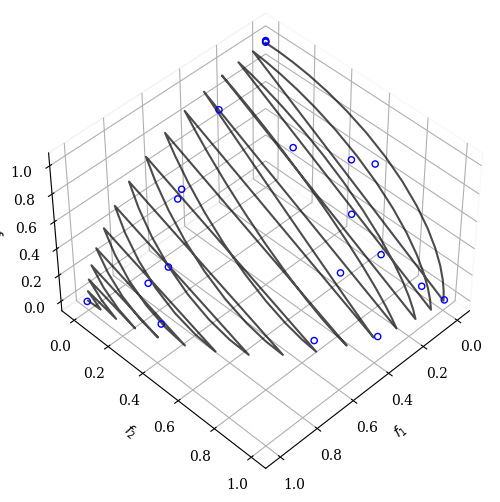

In [40]:
plot1 = Scatter()
plot1.add(nsga2_zdt1.F, facecolor='none', edgecolor='red')
plot1.add(zdt1.pareto_front(), plot_type='line', color='black', alpha=0.7)
plot1.show()

plot2 = Scatter()
plot2.add(nsga2_zdt3.F, facecolor='none', edgecolor='green')
plot2.add(zdt3.pareto_front(), plot_type='line', color='black', alpha=0.7)
plot2.show()

plot3 = Scatter()
plot3.add(nsga2_dtlz2.F, facecolor='none', edgecolor='blue')
plot3.add(dtlz2.pareto_front(), plot_type='line', color='black', alpha=0.7)
plot3.show()

### SMSEMOA

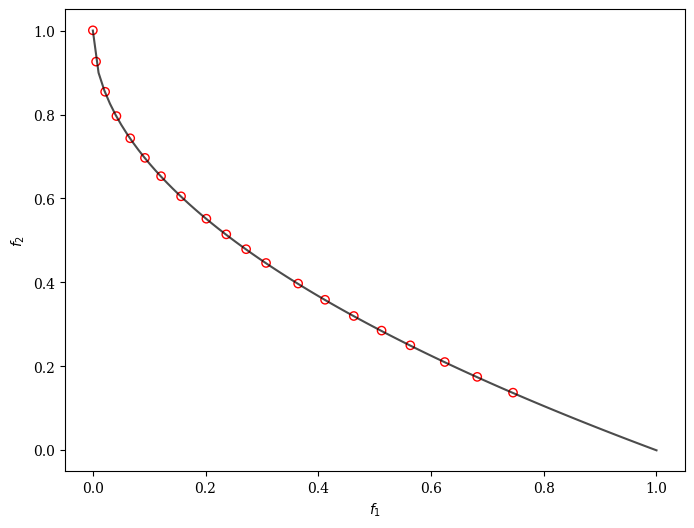

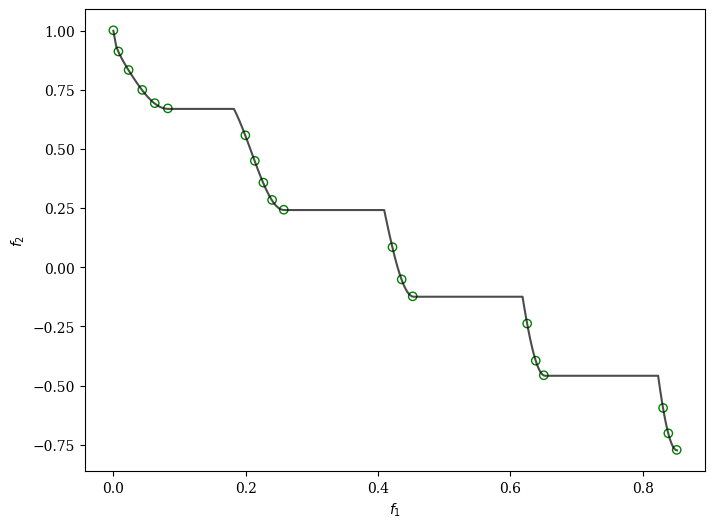

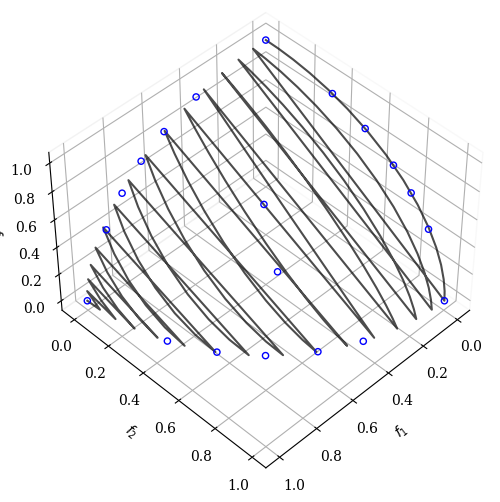

In [41]:
plot1 = Scatter()
plot1.add(sms_zdt1.F, facecolor='none', edgecolor='red')
plot1.add(zdt1.pareto_front(), plot_type='line', color='black', alpha=0.7)
plot1.show()

plot2 = Scatter()
plot2.add(sms_zdt3.F, facecolor='none', edgecolor='green')
plot2.add(zdt3.pareto_front(), plot_type='line', color='black', alpha=0.7)
plot2.show()

plot3 = Scatter()
plot3.add(sms_dtlz2.F, facecolor='none', edgecolor='blue')
plot3.add(dtlz2.pareto_front(), plot_type='line', color='black', alpha=0.7)
plot3.show()